# Thresholding

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### simple thresholding

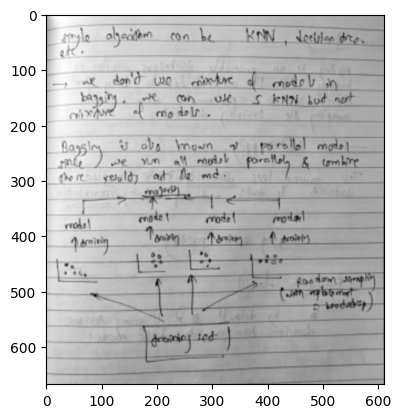

In [3]:
image = cv2.imread("../images/handwritten.png", 0)

plt.imshow(image, cmap='grey')

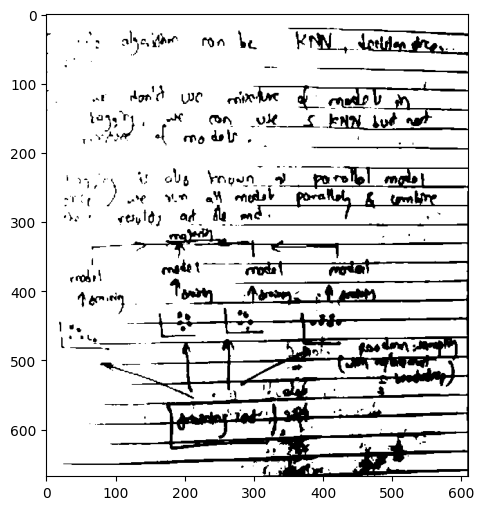

In [8]:
retval, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,6))

plt.imshow(binary, cmap='grey')
plt.show()

### Adaptive thresholding

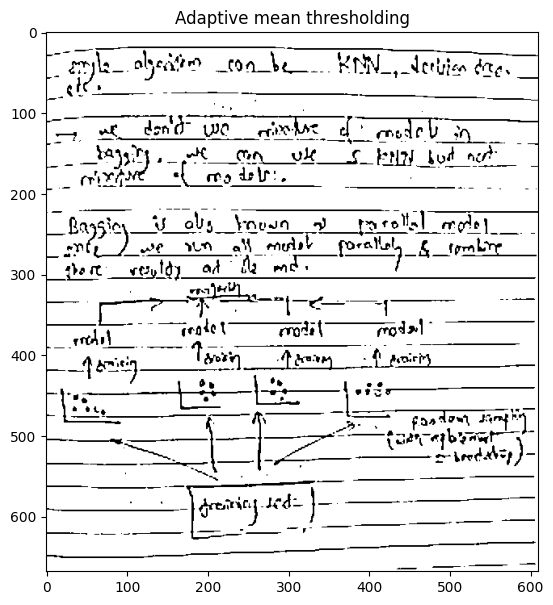

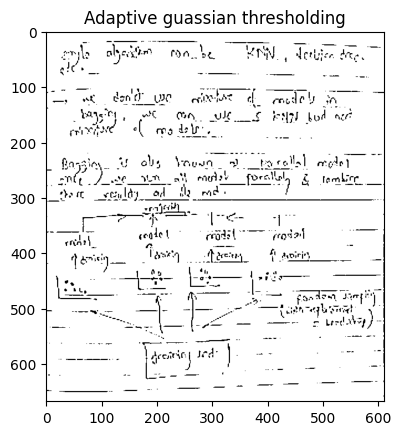

In [9]:
adaptive_m = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 15)

adaptive_g = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 15)

plt.figure(figsize=(12,7))

plt.imshow(adaptive_m, cmap='grey')
plt.title("Adaptive mean thresholding")
plt.show()

plt.imshow(adaptive_g, cmap='grey')
plt.title("Adaptive guassian thresholding")
plt.show()

# kmeans clustering

In [10]:
image = cv2.imread("../images/shapes.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
print(pixel_values)

[[247. 247. 247.]
 [247. 247. 247.]
 [247. 247. 247.]
 ...
 [247. 247. 247.]
 [247. 247. 247.]
 [247. 247. 247.]]


In [11]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3

_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [12]:
print(labels.shape)
print(centers)

(25000000, 1)
[[242.43665  242.43665  242.43665 ]
 [ 26.225998 149.96559  171.44696 ]
 [246.10536  126.51453   67.93914 ]]


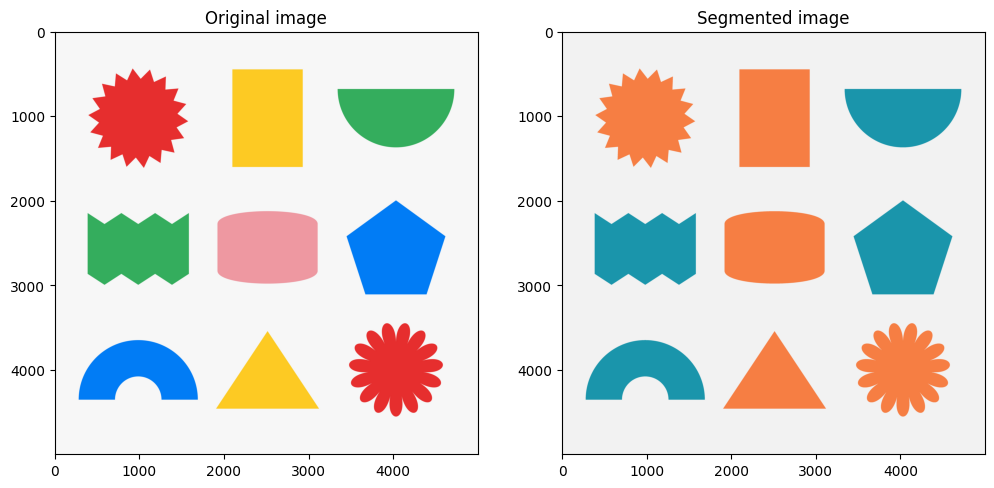

In [13]:
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# 1 --> [255, 255, 255]
# 0 --> [70,110, 167]

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("Segmented image")

plt.show()

# watershed algorithm

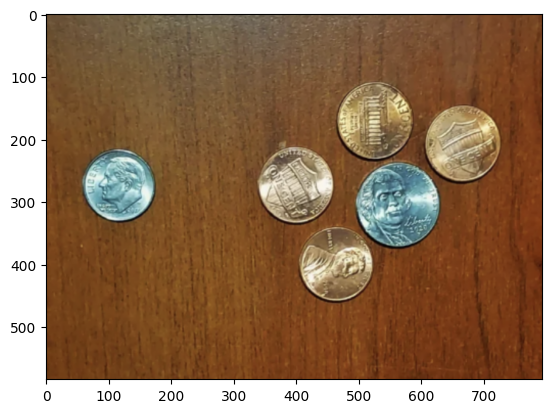

In [17]:
image = cv2.imread("../images/coins.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image.copy()
plt.imshow(image)

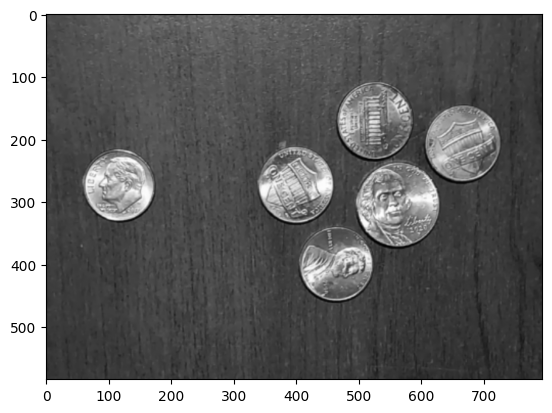

In [18]:
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap='grey')

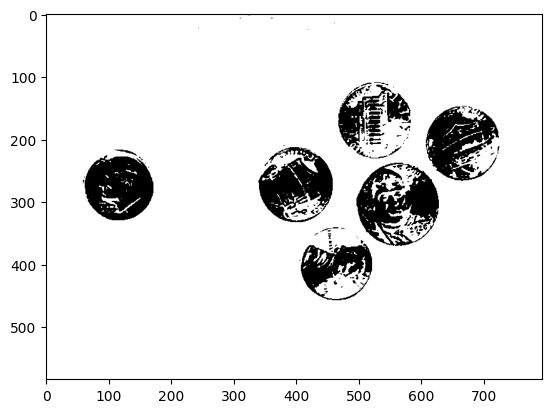

In [19]:
_, thresh = cv2.threshold(grey, 130, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='grey')

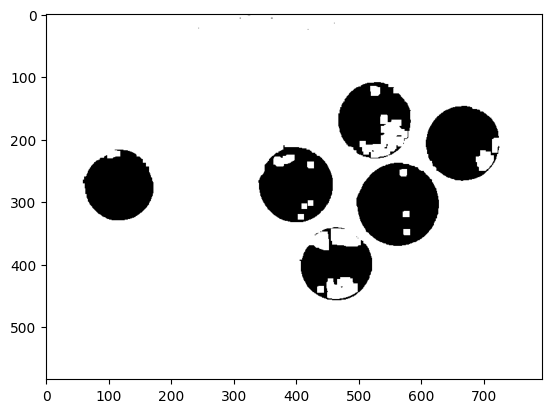

In [20]:
kernel = np.ones((3,3), np.uint8)
opeaning = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

plt.imshow(opeaning, cmap='grey')

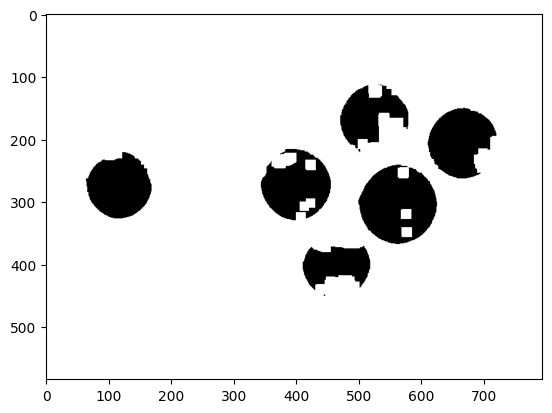

In [21]:
sure_bg = cv2.dilate(opeaning, kernel, iterations=3)
plt.imshow(sure_bg, cmap='grey')

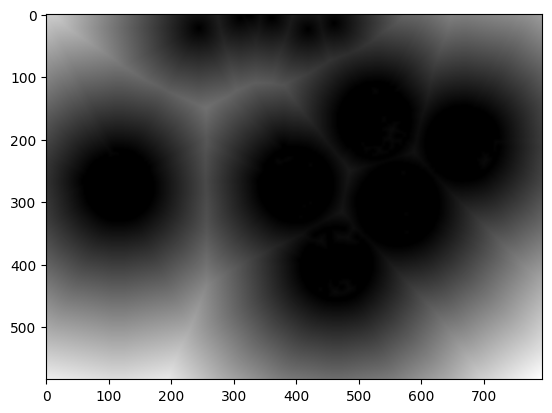

In [22]:
dist_transform = cv2.distanceTransform(opeaning, cv2.DIST_L2, 5)

plt.imshow(dist_transform, cmap='grey')

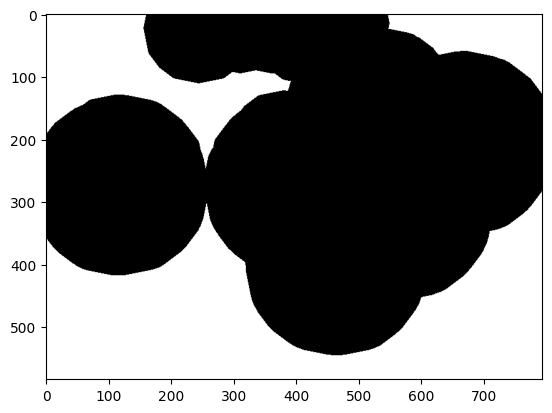

In [23]:
_, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)

plt.imshow(sure_fg, cmap='grey')

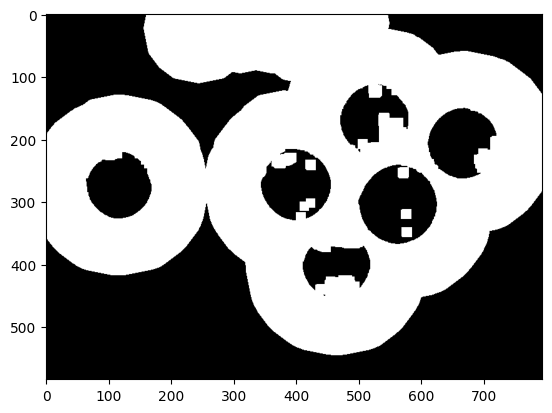

In [24]:
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='grey')

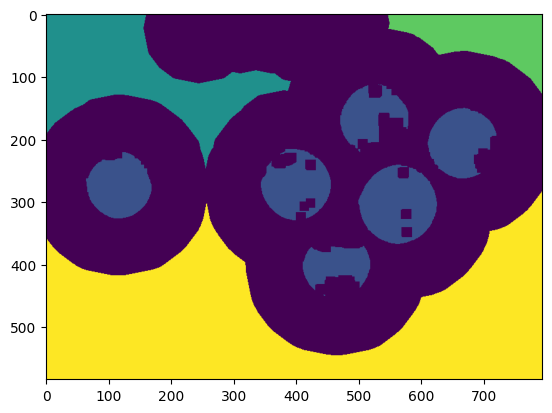

In [25]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown== 255] = 0

plt.imshow(markers)

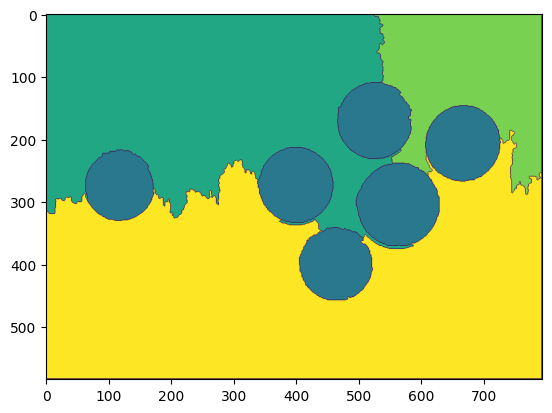

In [26]:
markers = cv2.watershed(image, markers)
plt.imshow(markers)

In [27]:
coin_mask = np.zeros_like(grey)

print(grey.shape)
print(coin_mask.shape)

unique_labels = np.unique(markers)

instance_number = 1
font = cv2.FONT_HERSHEY_SIMPLEX

for label in unique_labels:
    if label == 0 or label == -1:
        continue

    mask = np.uint8(markers == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimerter = cv2.arcLength(contour,True)

        if perimerter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimerter * perimerter))

        if 0.7 < circularity < 1.2 and area > 1000:
            cv2.drawContours(original_image, [contour], -1, (0,255,0), 2)
            x, y, w, h = cv2.boundingRect(contour)
            cv2.putText(original_image, f'Coin {instance_number}', (x, y-10), font, 0.6, (255,0, 0), 2)
            coin_mask = cv2.bitwise_or(coin_mask, mask)
            cv2.rectangle(original_image,(x-5, y-5), (x+w+5, y+h+5), (160, 150, 250), 2)
            instance_number += 1


(584, 794)
(584, 794)


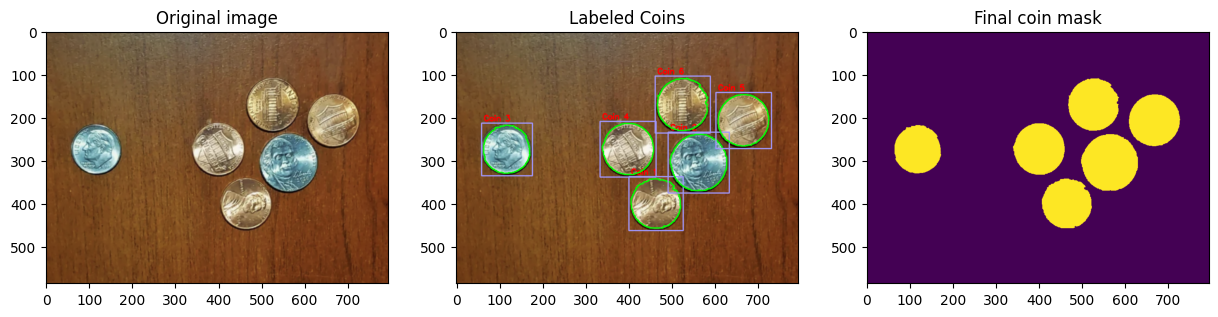

In [28]:
plt.figure(figsize=(15,10))


plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original image")

plt.subplot(1,3,2)
plt.imshow(original_image)
plt.title("Labeled Coins")

plt.subplot(1,3,3)
plt.imshow(coin_mask)
plt.title("Final coin mask")

plt.show()